In [2]:
# !python3 -m venv myenv
# !source myenv/bin/activate
!pip uninstall pandas -y
!pip install --upgrade pip > installations.txt
!pip install pandas==1.4.3 pyarrow yellowbrick polars transformers nltk gensim lightautoml > installations.txt


Found existing installation: pandas 1.4.3
Uninstalling pandas-1.4.3:
  Successfully uninstalled pandas-1.4.3


In [3]:
!pip uninstall torch -y
!pip install torch==2.1.0

Found existing installation: torch 2.0.0
Uninstalling torch-2.0.0:
  Successfully uninstalled torch-2.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 677.2 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 5.2 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: triton
    Found existing installation: triton 2.0.0
    Uninstalling triton-2.0.0:
      Successfully uninstalled triton-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightautoml 0.3.8.1 requires torch<=2.0.0,>=1.9.0, but you have torch 2.1.0 which is incompatible.


In [4]:
import polars as pl
import numpy as np
import pyarrow as pa
import os
import time
import optuna
import requests
import sys
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from copy import deepcopy as copy
import torch.nn as nn
from collections import OrderedDict
from collections import Counter

from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import ImportanceCutoffSelector, ModelBasedImportanceEstimator
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.automl.blend import WeightedBlender
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/kaggle/input/sbermarket-internship-competition/sample_submission.csv
/kaggle/input/sbermarket-internship-competition/train.csv


In [5]:
print(pd.__version__)

1.4.3


In [12]:
def ohe_data(raw: pl.DataFrame) -> pl.DataFrame:
    """
    Вовращает ohe матрицу для категорий.

    Args:
        raw (pl.DataFrame): Polars DataFrame.

    Returns:
        (tpl.DataFrame).
    """

    # OHE 'cart', группировка по юзеру и дате заказа по максимальным значениям
    # Таким образом для каждой категории, если она была в этот день в заказе у пользователя, будет 1
    train_raw = raw.to_dummies(columns='cart').group_by(['user_id', 'order_completed_at']).max()
    train_raw = train_raw.sort(['user_id', 'order_completed_at'])

    return train_raw
    
def sep_history(train_raw: pl.DataFrame) -> tuple[pl.DataFrame, pl.DataFrame]:
    """
    Обрабатывает датафрейм polars и возвращает обработынный тренировочный и валидационный датасеты.

    Args:
        raw (pl.DataFrame): Polars DataFrame для обработки.

    Returns:
        tuple[pl.DataFrame, pl.DataFrame]: Обработанные DataFrame для train_data и valid_data.
    """
    
    # Вычисление переменных времени
    train_raw = train_raw.with_columns(pl.col("order_completed_at").str.to_datetime())
    train_raw = train_raw.with_columns(
        [
            (pl.col('user_id').cum_count() - pl.lit(1)).over(['user_id']).alias('order_number'),
            pl.col("order_completed_at").dt.hour().alias("hour"),
            pl.col("order_completed_at").dt.week().alias("week"),
            pl.col("order_completed_at").dt.weekday().alias("weekday"),
            pl.col("order_completed_at").dt.day().alias("day"),
            pl.col("order_completed_at").dt.month().alias("month"),
            pl.col("order_completed_at").dt.year().alias("year"),
        ]
    )
    train_raw = train_raw.drop('order_completed_at')
    
    # Сепарация последнего заказа из истории заказов
    grouped = train_raw.group_by('user_id').agg(pl.max('order_number').alias('max_order_number'))
    merged = train_raw.join(grouped, on='user_id')
    last_order = merged['max_order_number'] == merged['order_number']

    # Разделение на train_data (заказы, кроме последнего) и valid_data (последний заказ) .group_by('user_id').sum()
    train_data = train_raw.filter(~last_order)
    valid_data = train_raw.filter(last_order).drop('hour', 'week', 'weekday', 'day', 'month', 'year')

    return train_data, valid_data

def create_dataset(train_data: pl.DataFrame, valid_data: pl.DataFrame)-> pd.DataFrame:
    """
    Компилирует историю заказов (train_data) и последний заказ (valid_data) в укомплектованный тренировочный pd.Dataframe "Train".

    Args:
        train_data (pl.DataFrame): история заказов (корзина на каждого юзера).
        valid_data (pl.DataFrame): последний заказ (корзина на каждого юзера).

    Returns:
        pd.DataFrame: X + Y for model.
    """
    # Преобразование в длинный формат юзера и категории товара
    train_melt = train_data.drop('order_number').melt(id_vars=['user_id', 'hour', 'week', 'weekday', 'day', 'month', 'year'], variable_name='category', value_name='ordered')
    valid_melt = val_data.drop('order_number',).melt(id_vars=['user_id', ], variable_name='category', value_name='target')

    # Тренировочный датасет
    Train = train_melt
    order_number_df = val_data.select(['user_id', 'order_number']).unique() # Количество заказов у юзера
    dl_tmp = Train.group_by('category').agg(pl.col(['ordered']).sum()) # Количество заказов по категории
    Train = Train.join(order_number_df, on='user_id').rename({"order_number": "total_order_num"})
    Train = Train.join(dl_tmp, on='category').rename({"ordered_right": "total_order_in_cat"})
    # Вычисление рейтинга для каждой записи
    Train = Train.with_columns(
        [
            (pl.col('ordered') / pl.col('total_order_num')).alias('total_rating'),
            (pl.col('user_id').cast(pl.Utf8) + ';' + pl.col('category')).alias('id')
        ]
    )
    Train = Train.group_by('user_id', 'category', 'id').agg(
        pl.col(['hour']).mean().name.suffix("_mean"), pl.col(['hour']).max().name.suffix("_max"),
        pl.col(['hour']).min().name.suffix("_min"), pl.col(['hour']).std().name.suffix("_std"),
        pl.col(['week']).mean().name.suffix("_mean"), pl.col(['week']).max().name.suffix("_max"),
        pl.col(['week']).min().name.suffix("_min"), pl.col(['week']).std().name.suffix("_std"),
        pl.col(['weekday']).mean().name.suffix("_mean"), pl.col(['weekday']).max().name.suffix("_max"),
        pl.col(['weekday']).min().name.suffix("_min"), pl.col(['weekday']).std().name.suffix("_std"),
        pl.col(['day']).mean().name.suffix("_mean"), pl.col(['day']).max().name.suffix("_max"),
        pl.col(['day']).min().name.suffix("_min"), pl.col(['day']).std().name.suffix("_std"),
        pl.col(['month']).mean().name.suffix("_mean"), pl.col(['month']).max().name.suffix("_max"),
        pl.col(['month']).min().name.suffix("_min"), pl.col(['month']).std().name.suffix("_std"),
        pl.col(['year']).mean().name.suffix("_mean"), pl.col(['year']).max().name.suffix("_max"),
        pl.col(['year']).min().name.suffix("_min"), pl.col(['year']).std().name.suffix("_std"),
        pl.col(['total_rating']).mean().name.suffix("_mean"), pl.col(['total_rating']).max().name.suffix("_max"),
        pl.col(['total_rating']).min().name.suffix("_min"), pl.col(['total_rating']).std().name.suffix("_std"),
        pl.col(['ordered']).mean().name.suffix("_mean"), pl.col(['ordered']).max().name.suffix("_max"),
        pl.col(['ordered']).min().name.suffix("_min"), pl.col(['ordered']).std().name.suffix("_std"),
        pl.col(['total_order_in_cat']).mean().name.suffix("_mean"), pl.col(['total_order_in_cat']).max().name.suffix("_max"),
        pl.col(['total_order_in_cat']).min().name.suffix("_min"), pl.col(['total_order_in_cat']).std().name.suffix("_std"),
        pl.col(['total_order_num']).mean().name.suffix("_mean"), pl.col(['total_order_num']).max().name.suffix("_max"),
        pl.col(['total_order_num']).min().name.suffix("_min"), pl.col(['total_order_num']).std().name.suffix("_std"),
    )
    # Вычисление рейтинга по времени
    rating_per_hour = Train.group_by(['year_mean', 'month_mean', 'hour_mean', 'user_id']).agg(
        ((pl.col("total_rating_mean").mean()) * 100).alias("rating_per_hour_mean"),
        ((pl.col("total_rating_mean").std()) * 100).alias("rating_per_hour_std"),
        ((pl.col("total_rating_mean").sum())).alias("rating_per_hour_sum"),
        ((pl.col("total_rating_mean").median()) * 100).alias("rating_per_hour_median"),
    )

    rating_per_weekday = Train.group_by(['year_mean', 'month_mean', 'weekday_mean', 'user_id']).agg(
        ((pl.col("total_rating_mean").mean()) * 100).alias("rating_per_w_mean"),
        ((pl.col("total_rating_mean").std()) * 100).alias("rating_per_w_std"),
        ((pl.col("total_rating_mean").sum())).alias("rating_per_w_sum"),
        ((pl.col("total_rating_mean").median()) * 100).alias("rating_per_w_median"),
    )
    rating_per_day = Train.group_by(['year_mean', 'month_mean', 'day_mean', 'user_id']).agg(
        ((pl.col("total_rating_mean").mean()) * 100).alias("rating_per_d_mean"),
        ((pl.col("total_rating_mean").std()) * 100).alias("rating_per_d_std"),
        ((pl.col("total_rating_mean").sum())).alias("rating_per_d_sum"),
        ((pl.col("total_rating_mean").median()) * 100).alias("rating_per_d_median"),
    )

    rating_per_month = Train.group_by(['year_mean', 'month_mean', 'user_id']).agg(
        ((pl.col("total_rating_mean").mean()) * 100).alias("rating_per_m_mean"),
        ((pl.col("total_rating_mean").std()) * 100).alias("rating_per_m_std"),
        ((pl.col("total_rating_mean").sum())).alias("rating_per_m_sum"),
        ((pl.col("total_rating_mean").median()) * 100).alias("rating_per_m_median"),
    )


    Train = Train.join(rating_per_month, on=['year_mean', 'month_mean', 'user_id'])
    Train = Train.join(rating_per_weekday, on=['year_mean', 'month_mean', 'weekday_mean', 'user_id'])
    Train = Train.join(rating_per_day, on=['year_mean', 'month_mean', 'day_mean', 'user_id'])
    Train = Train.join(rating_per_hour, on=['year_mean', 'month_mean', 'hour_mean', 'user_id'])
    
    # Присоединение целевой переменной из valid_melt к Train
    Train = Train.join(valid_melt, on = ['user_id', 'category'])
#     Train = Train.drop('user_id', 'category')

    # Преобразование в pandas DataFrame
    Train = Train.to_pandas()
    Train['id'] = Train['id'].str.replace('cart_', '')
    Train['category'] = Train['category'].str.replace('cart_', '')

    return Train

In [7]:
# tmp импорт в pandas

raw = pd.read_csv('../input/sbermarket-internship-competition/train.csv')
sub = pd.read_csv('../input/sbermarket-internship-competition/sample_submission.csv', sep = ",")

# Приведение столбца 'cart' к int
raw['cart'] = raw['cart'].astype(int)

def filter_raw_data(raw, sub):
    users = map(int, (x.split(';')[0] for x in sub['id']))
    user_counts = Counter(users)
    frequent_users = {user for user, count in user_counts.items() if count > 25}
    filtered_raw = raw[raw['user_id'].isin(frequent_users)]
    filtered_sub = sub[sub['id'].apply(lambda x: int(x.split(';')[0])).isin(frequent_users)]
    total_count = sum(user_counts.values())
    frequent_count = sum(count for user, count in user_counts.items() if user in frequent_users)
    proportion = frequent_count / total_count
    
    return filtered_raw, filtered_sub, proportion

filtered_raw, filtered_sub, proportion = filter_raw_data(raw, sub)
print(f"Процент наблюдений, используемый для тренировки: {proportion:.2f}%")

Процент наблюдений, используемый для тренировки: 0.97%


In [13]:
%%time
# filtered_raw = pl.from_pandas(filtered_raw)
# train_raw = ohe_data(filtered_raw)
# train_data, val_data = sep_history(train_raw)
Train = create_dataset(train_data, val_data)

CPU times: user 5min 30s, sys: 2min 9s, total: 7min 40s
Wall time: 50.1 s


In [15]:
Train

,user_id,category,id,hour_mean,hour_max,hour_min,hour_std,week_mean,week_max,week_min,...,rating_per_w_median,rating_per_d_mean,rating_per_d_std,rating_per_d_sum,rating_per_d_median,rating_per_hour_mean,rating_per_hour_std,rating_per_hour_sum,rating_per_hour_median,target
0,0,0,0;0,8.500000,9,8,0.707107,32.000000,35,29,...,0.0,0.966042,5.660171,8.250000,0.0,0.966042,5.660171,8.250000,0.0,0
1,3,0,3;0,13.833333,19,10,3.488075,28.666667,48,15,...,0.0,0.152875,0.820443,1.305556,0.0,0.152875,0.820443,1.305556,0.0,0
2,4,0,4;0,9.428571,16,6,3.823486,20.571429,28,16,...,0.0,0.241361,1.196201,2.061224,0.0,0.241361,1.196201,2.061224,0.0,0
3,5,0,5;0,12.642857,20,6,4.877060,29.142857,35,23,...,0.0,0.066315,0.281990,0.566327,0.0,0.066315,0.281990,0.566327,0.0,0
4,7,0,7;0,11.800000,18,5,4.211096,12.100000,26,1,...,0.0,0.100703,0.461075,0.860000,0.0,0.100703,0.461075,0.860000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9838929,19991,99,19991;99,9.000000,12,6,4.242641,35.000000,35,35,...,0.0,0.731850,4.387127,6.250000,0.0,0.731850,4.387127,6.250000,0.0,0
9838930,19992,99,19992;99,10.500000,12,9,2.121320,35.000000,35,35,...,0.0,1.083138,5.638909,9.250000,0.0,1.083138,5.638909,9.250000,0.0,0
9838931,19993,99,19993;99,9.666667,11,7,2.309401,35.666667,36,35,...,0.0,0.403331,2.278648,3.444444,0.0,0.403331,2.278648,3.444444,0.0,0
9838932,19994,99,19994;99,11.500000,16,8,3.696846,35.500000,36,35,...,0.0,0.219555,1.265042,1.875000,0.0,0.219555,1.265042,1.875000,0.0,0


In [17]:
x_cols = Train.select_dtypes(include=['int', 'int8', 'int32', 'uint32', 'uint8', 'float']).drop(columns = ['user_id', 'target'], axis = 1).columns.tolist()
print(x_cols)
y_cols = ['target']
print(y_cols)

['hour_mean', 'hour_max', 'hour_min', 'hour_std', 'week_mean', 'week_max', 'week_min', 'week_std', 'weekday_mean', 'weekday_max', 'weekday_min', 'weekday_std', 'day_mean', 'day_max', 'day_min', 'day_std', 'month_mean', 'month_max', 'month_min', 'month_std', 'year_mean', 'year_max', 'year_min', 'year_std', 'total_rating_mean', 'total_rating_max', 'total_rating_min', 'total_rating_std', 'ordered_mean', 'ordered_max', 'ordered_min', 'ordered_std', 'total_order_in_cat_mean', 'total_order_in_cat_max', 'total_order_in_cat_min', 'total_order_in_cat_std', 'total_order_num_mean', 'total_order_num_max', 'total_order_num_min', 'total_order_num_std', 'rating_per_m_mean', 'rating_per_m_std', 'rating_per_m_sum', 'rating_per_m_median', 'rating_per_w_mean', 'rating_per_w_std', 'rating_per_w_sum', 'rating_per_w_median', 'rating_per_d_mean', 'rating_per_d_std', 'rating_per_d_sum', 'rating_per_d_median', 'rating_per_hour_mean', 'rating_per_hour_std', 'rating_per_hour_sum', 'rating_per_hour_median']
['tar

In [21]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [22]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
scaler = RobustScaler()

s_Train = Train.copy()
s_Train[x_cols] = scaler.fit_transform(s_Train[x_cols])

pca = PCA(n_components=21)

s_Train_pca = pca.fit_transform(s_Train[x_cols])
# test_X_scaled = pca.transform(test_X_scaled)

Train_pca = pd.DataFrame(s_Train_pca, columns=[f'pc{i+1}' for i in range(s_Train_pca.shape[1])])
Train_pca['target'] = Train['target'].values
Train_pca['id'] = Train['id'].values

Elbow Method to determine the number of clusters to be formed:


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

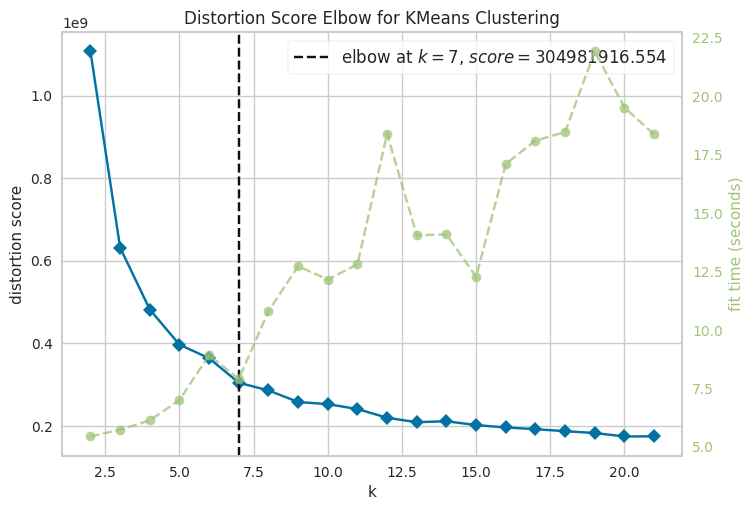

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
print('Elbow Method to determine the number of clusters to be formed:')
warnings.filterwarnings("ignore", message="findfont:.*")
Elbow_M = KElbowVisualizer(KMeans(), k=21)
Elbow_M.fit(Train_pca.drop(columns = ['id', 'target'], axis = 1))
Elbow_M.show()

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7)
yhat_kmeans = kmeans.fit_predict(Train_pca.drop(columns=['id', 'target']))

# Добавление информации о кластерах в исходный датафрейм
Train_pca["Clusters"] = yhat_kmeans
s_Train["Clusters"] = yhat_kmeans
Train["Clusters"] = yhat_kmeans

In [20]:
# Train.to_parquet('Train.parquet', index=False)
Train_pca.to_parquet('s_Train_pca.parquet', index=False)

In [35]:
N_THREADS = 2 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TARGET_NAME = 'target' # Target column name
TIMEOUT = 300

In [36]:
Train_set, Valid_set = train_test_split(Train_pca, test_size = TEST_SIZE,
                                        stratify = None, random_state = 23)
Train_set.reset_index(drop=True, inplace=True)
Valid_set.reset_index(drop=True, inplace=True)

In [ ]:
%%time
model0 = BoostLGBM(
    default_params={'learning_rate': 0.05, 'num_leaves': 64, 'seed': 42, 'num_threads': N_THREADS}
)
pipe0 = LGBSimpleFeatures()
mbie = ModelBasedImportanceEstimator()
selector = ImportanceCutoffSelector(pipe0, model0, mbie, cutoff=0)

pipe = LGBSimpleFeatures()

params_tuner1 = OptunaTuner(n_trials=20, timeout=30) # stop after 20 iterations or after 30 seconds
model1 = BoostLGBM(
    default_params={'learning_rate': 0.05, 'num_leaves': 128, 'seed': 1, 'num_threads': N_THREADS}
)
model2 = BoostLGBM(
    default_params={'learning_rate': 0.025, 'num_leaves': 64, 'seed': 2, 'num_threads': N_THREADS}
)

pipeline_lvl1 = MLPipeline([
    (model1, params_tuner1),
    model2
], pre_selection=selector, features_pipeline=pipe, post_selection=None)

pipe1 = LGBSimpleFeatures()

model = BoostLGBM(
    default_params={'learning_rate': 0.05, 'num_leaves': 64, 'max_bin': 1024, 'seed': 3, 'num_threads': N_THREADS},
    freeze_defaults=True
)

pipeline_lvl2 = MLPipeline([model], pre_selection=None, features_pipeline=pipe1, post_selection=None)

In [ ]:
# Подключение TPU
import tensorflow as tf

# Создание кластера TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# Соединение кластера
tf.config.experimental_connect_to_cluster(tpu)

# Инициализация TPU системы
tf.tpu.experimental.initialize_tpu_system(tpu)

# Создание стратегии распределения на TPU
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Здесь следует разместить весь код обучения модели, чтобы TensorFlow автоматически распределял вычисления на все ядра TPU


In [48]:

Train_set.reset_index(drop=True, inplace=True)
Valid_set.reset_index(drop=True, inplace=True)

In [49]:
Train_set.iloc[:1000]

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc15,pc16,pc17,pc18,pc19,pc20,pc21,target,id,Clusters
0,-5.339852,9.553817,1.996214,-0.793821,-3.059995,-2.399536,-0.952912,1.282882,1.540169,0.128879,...,0.034012,-0.090531,0.684393,0.231988,-0.055866,0.380873,-0.097307,0,16229;546,5
1,-3.083663,-2.119453,-2.239829,-0.667327,1.385995,0.213023,-1.312077,0.246792,-1.299856,-1.510207,...,-0.173388,0.458214,-0.304547,0.112527,0.047109,0.064252,-0.023705,0,9434;200,6
2,-4.406759,3.740275,0.048166,-0.472098,1.648817,2.300936,-0.849842,-1.045969,0.407445,-1.116076,...,0.072908,0.215739,-0.043203,-0.194010,0.021456,0.389866,-0.020045,0,3137;152,5
3,-5.341916,-1.353231,-2.002590,-0.255896,0.086948,1.352988,0.147466,-0.415481,1.521106,0.381955,...,0.025201,0.205500,-0.026913,-0.429190,0.006589,0.125727,0.112726,0,16507;747,6
4,-5.329322,-3.918434,2.018499,1.907498,0.436435,0.168388,-0.280758,-0.197736,-0.008165,-0.431902,...,-0.565620,0.022700,0.150657,0.193245,0.061297,-0.039039,0.435274,0,984;529,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-5.228681,-2.981930,0.128158,2.278724,0.077666,-0.801055,-0.859310,0.990556,-1.151965,1.226886,...,-0.035795,-0.315473,-0.250574,0.458433,0.042444,0.392785,0.319933,0,1224;452,0
996,-5.346117,1.807072,0.933156,2.254756,2.298334,-1.163629,0.407368,-0.121358,0.640341,-1.583119,...,0.526778,0.418936,-0.536185,0.123616,0.053585,0.189111,-0.047729,0,5222;709,6
997,-5.339826,0.747536,-1.788698,-0.646207,1.693199,-1.775260,-1.794778,0.392269,0.857018,0.786611,...,0.072593,0.687930,-0.296091,-0.330335,0.002925,0.257121,0.033486,0,13207;787,6
998,-5.260162,6.229031,3.403876,4.151849,1.035832,-3.223829,2.599473,-0.720178,-0.025365,-2.578109,...,0.186263,0.147364,0.060943,-0.186865,0.004709,-0.176515,-0.162110,0,7578;481,5


In [55]:
%%time 
def f1 (real, pred, **kwargs):
    return f1_score(real, (pred > 0.5).astype(int), **kwargs)

ROLES = {'target': TARGET_NAME, 'drop': ['id']}
TASK = Task('binary', metric = f1)
reader = PandasToPandasReader(TASK, cv=N_FOLDS, random_state=RANDOM_STATE)

# default_lama_params = {
#     "task": TASK,
#     "timeout": TIMEOUT,
#     "cpu_limit": N_THREADS,
#     "reader_params": {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
# }
    
# automl = TabularAutoML(
#     **default_lama_params,
#     general_params = {"use_algos": [["lgb", "mlp", "dense"]]},
#     nn_params = {"n_epochs": 10, "bs": 150, "num_workers": 2}
   
# )
# automl = TabularAutoML(task = TASK, 
#                        timeout = 300,
#                        cpu_limit = 4,
#                        reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 23},
#                        general_params = {'use_algos': [['linear_l2']]},
#                       )

automl = AutoML(reader, [
    [pipeline_lvl1],
    [pipeline_lvl2],
], skip_conn=False)

train_pred = automl.fit_predict(Train_set, roles = ROLES, verbose = 3)
print('Score', "%.5f" % f1(Train_set.target, train_pred.data))
valid_pred = automl.predict(Valid_set)
print('Score on out of folds validation', "%.5f" % f1(Valid_set.target, valid_pred.data))

[16:47:41] Stdout logging level is INFO3.
[16:47:41] Task: binary

[16:47:41] Start automl preset with listed constraints:
[16:47:41] - time: 300.00 seconds
[16:47:41] - CPU: 4 cores
[16:47:41] - memory: 16 GB

[16:47:41] Train data shape: (7871147, 24)

[16:47:53] Feats was rejected during automatic roles guess: []
[16:47:54] Layer 1 train process start. Time left 286.47 secs


KeyboardInterrupt: 

In [ ]:
best_score = 0
for i in np.arange(0.01, 1.0, 0.01):
    score = f1 = f1_score(Valid_set.target, (valid_pred.data > i).astype(int))
    if score > best_score:
        best_score = score
        proba_split = i

print('At i =', "%.2f" % proba_split,'score is : ' "%.5f" % best_score)

In [ ]:
Train

In [ ]:
Test = Train.copy()
Test['order_number'] += 1 
Test['ordered'] = Test['ordered'] + Test['target']
test_total_ordered = Test.groupby('category')['ordered'].sum()
Test['total_ordered'] = Test['category'].map(test_total_ordered)
Test['rating'] = Test['ordered'] / Test['order_number']
Test = Test.drop('target', axis=1)
Test.head(3)

In [ ]:
predictions = automl.predict(Test)
print('Train target mean:', "%.5f" % Train.target.mean())
print('Test target mean:', "%.5f" % (predictions.data > 0.5).astype(int).mean())

In [ ]:
th = 0.5
train_mean = Train.target.mean()
test_mean = (predictions.data > th).astype(int).mean()

while test_mean < train_mean:
    th -= 0.005
    test_mean = (predictions.data > th).astype(int).mean()
    
print('Threshold:', "%.4f" % th)
print('Train mean:', "%.5f" % train_mean)
print('New Test mean:', "%.5f" % test_mean)

In [ ]:
Test['target'] = (predictions.data > th).astype(int)
submit = pd.merge(sub['id'], Test[['id', 'target']], on='id')

In [ ]:
import csv

with open('submission.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(submit.columns)
    for row in submit.values:
        csvwriter.writerow(row)

In [ ]:
submit